In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [4]:
## Find all the tiffiles in the tif path
tif_path = r'/mnt/md0/data/Coconut'
tifs = tfu.get_tif_paths(tif_path)[:1]

In [5]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 0.1
}

In [6]:
# Create the job
job = Job('/mnt/md0/runs','Coconut-Demo', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-Coconut-Demo already exists
Loading job directory for Coconut-Demo in /mnt/md0/runs
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


In [7]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# use all of the frames in the loaded init files 
# if your files are really big, set this to <500 total
job.params['init_n_frames'] = 200

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None

   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-Coconut-Demo/summary/summary.npy
Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


Loaded 1 files, total 18.79 GB
   Selecting 200 random frames from the init tif files
   Loaded movie with 200 frames and shape 30, 584, 584
         Enforcing positivity in mean image


/home/ali/packages/s2p-lbm/suite3d/utils.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to /mnt/md0/runs/s3d-Coconut-Demo/summary/crosstalk_plots
saved
Close figure


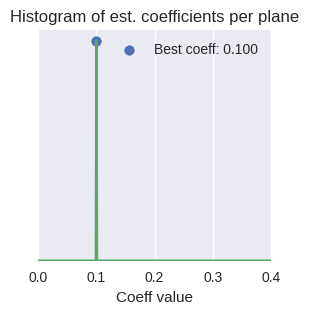

   Subtracting with estimated coefficient 0.100
          Subtracting plane 0 from 15
           Corresponds to index 0 from 15
          Subtracting plane 1 from 16
           Corresponds to index 1 from 16
          Subtracting plane 2 from 17
           Corresponds to index 2 from 17
          Subtracting plane 3 from 18
           Corresponds to index 3 from 18
          Subtracting plane 4 from 19
           Corresponds to index 4 from 19
          Subtracting plane 5 from 20
           Corresponds to index 5 from 20
          Subtracting plane 6 from 21
           Corresponds to index 6 from 21
          Subtracting plane 7 from 22
           Corresponds to index 7 from 22
          Subtracting plane 8 from 23
           Corresponds to index 8 from 23
          Subtracting plane 9 from 24
           Corresponds to index 9 from 24
          Subtracting plane 10 from 25
           Corresponds to index 10 from 25
          Subtracting plane 11 from 26
           Corresponds to index

/home/ali/packages/s2p-lbm/suite2p/suite2p/registration/register.py:89: RuntimeWarning: invalid value encountered in matmul
  cc = np.matmul(frames, frames.T)


        Computed reference for plane 0
        Computed reference for plane 1
        Computed reference for plane 2
        Computed reference for plane 3
        Computed reference for plane 4
        Computed reference for plane 5
        Computed reference for plane 6
        Computed reference for plane 7
        Computed reference for plane 8
        Computed reference for plane 9
        Computed reference for plane 10
        Computed reference for plane 11
        Computed reference for plane 12
        Computed reference for plane 13
        Computed reference for plane 14
        Computed reference for plane 15
        Computed reference for plane 16
        Computed reference for plane 17
        Computed reference for plane 18
        Computed reference for plane 19
        Computed reference for plane 20
        Computed reference for plane 21
        Computed reference for plane 22
        Computed reference for plane 23
        Computed reference for plane 24
        Co

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeErrorException ignored in: : Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeErrorException ignored in: : Undefined plan with nthreads. This is a bug
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in:     

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 

RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    
RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
: RuntimeErrorUndefined plan with nthreads. This is a bug: 
Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeError: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug

RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Exception ignored in: 
Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeErrorRuntimeError
: : RuntimeErrorUndefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug: 

Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: : 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug


Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeError
: Undefined plan with nthreads. This is a bugRuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug


: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: RuntimeError: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in:     FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'



RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: Traceback (most recent call last):
: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn



Traceback (most recent call last):
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,        
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeError

: RuntimeErrorRuntimeErrorUndefined plan with nthreads. This is a bug: : 
Undefined plan with nthreads. This is a bu

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
RuntimeError    

RuntimeError: Undefined plan with nthreads. This is a bug

: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 

RuntimeError: Undefined plan with nthreads. This is a bug


Undefined plan with nthreads. This is a bugRuntimeError: Exception ignored in: 
Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
Exception ignored in: 
RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError: 
: Undefined plan with nthreads. This is a bugTraceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: : 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in:     'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
Exception ignored in: 
Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

:     Traceback (most recent call last):
Undefined plan with nthreads. This is a bugFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
RuntimeErrorRuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
: : Exception ignored in: Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


    Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeError
: RuntimeErrorUndefined plan with nthreads. This is a bug: Undefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'



RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

RuntimeError    : FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeErrorException ignored in: : RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug: 

Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
Traceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    


RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
Exception ignored in: RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null': 
Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Traceback (most recent call last):
Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in:     'pyfftw.pyfftw._fftw_plan_with_nthreads_null'FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
RuntimeError    : FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 
Exception ignored in: RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null': 

Undefined plan with nthreads. This is a bugTraceback (most recent call last):
Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeErrorRuntimeError: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: 

RuntimeError: Undefined plan with nthreads. This is a bug

Undefined plan with nthreads. This is a bug
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
RuntimeError    : FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null': Exception ignored in: 
Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):


  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
RuntimeErrorUndefined plan with nthreads. This is a bug: 
Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError
RuntimeError: Exception ignored in: : Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Undefined plan with nthreads. This is a bug
Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null': 
Undefined plan with nthreads. This is a bugTraceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null': 
Undefined plan with nthreads. This is a bugTraceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in:     FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
RuntimeError  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
: Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeErrorRuntimeError: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: : 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
    Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

RuntimeError    : FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Undefined plan with nthreads. This is a bugTraceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in: 
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
    : Traceback (most recent call last):
Undefined plan with nthreads. This is a bugFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Exception ignored in: Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Exception ignored in: 
RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    : Traceback (most recent call last):

Undefined plan with nthreads. This is a bugFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

        RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 

Undefined plan with nthreads. This is a bugRuntimeErrorRuntimeError
: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: 

RuntimeError: Undefined plan with nthreads. This is a bug

Undefined plan with nthreads. This is a bugException ignored in: 
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeErrorRuntimeError: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug



Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeError
: RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: : 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: 

RuntimeError: Undefined plan with nthreads. This is a bug

Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
RuntimeError  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
:     FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug

RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

        Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeErrorRuntimeError: Traceback (most recent call last):
: Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeErrorRuntimeError: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in:     FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeErrorRuntimeError: : Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug



RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bugException ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,RuntimeError
RuntimeError: : Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

    Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: 


RuntimeError: Undefined plan with nthreads. This is a bug


'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in: Traceback (most recent call last):
RuntimeError
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug    
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):

      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
    Undefined plan with nthreads. This is a bugRuntimeError
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bug
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Exception ignored in: 

RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Exception ignored in:     
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):


  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Traceback (most recent call last):
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
:         Undefined plan with nthreads. This is a bugException ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
RuntimeErrorRuntimeError
: : Undefined plan with nthreads. This is a bugTraceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: Exception ignored in: Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null''pyfftw.pyfftw._fftw_plan_with_nthreads_null'


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorRuntimeErrorRuntimeErrorUndefined plan with nthreads. This is a bug
: : Traceback (most recent call last):
: Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

Undefined plan with nthreads. This is a bug
    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null': Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorTraceback (most recent call last):
:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Undefined plan with nthreads. This is a bug
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):

Exception ignored in:   File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
RuntimeError'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    
: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Traceback (most recent call last):

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Undefined plan with nthreads. This is a bug
RuntimeError    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError
: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeError: Undefined plan with nthreads. This is a bug


Exception ignored in: Traceback (most recent call last):
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

      File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
    RuntimeError
: Traceback (most recent call last):
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


    RuntimeErrorFFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,: 
Undefined plan with nthreads. This is a bugRuntimeError: 
Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

: Exception ignored in: Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    

RuntimeError: Undefined plan with nthreads. This is a bug

FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,Exception ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn


RuntimeError: Undefined plan with nthreads. This is a bug

    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'RuntimeError
: 

RuntimeError: Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
Undefined plan with nthreads. This is a bug  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

Traceback (most recent call last):
RuntimeError  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
: Undefined plan with nthreads. This is a bug    
FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: 

RuntimeError: Undefined plan with nthreads. This is a bug

Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeErrorException ignored in: : 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug

Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: : Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bug'pyfftw.pyfftw._fftw_plan_with_nthreads_null'


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
        FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError

RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Exception ignored in: : 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'Undefined plan with nthreads. This is a bugUndefined plan with nthreads. This is a bug


Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,


RuntimeError: Undefined plan with nthreads. This is a bug

RuntimeError: Undefined plan with nthreads. This is a bugException ignored in: 
'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):


RuntimeError: Undefined plan with nthreads. This is a bug

  File "/home/ali/anaconda3/envs/s2p-lbm/lib/python3.8/site-packages/pyfftw/builders/_utils.py", line 285, in _Xfftn
    Exception ignored in: FFTW_object = pyfftw.FFTW(input_array, output_array, axes, direction,

RuntimeError: Undefined plan with nthreads. This is a bug

'pyfftw.pyfftw._fftw_plan_with_nthreads_null'

RuntimeErrorException ignored in: Traceback (most recent call last):
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   Initial pass complete. See /mnt/md0/runs/s3d-Coconut-Demo/summary for details


In [14]:
job.run_init_pass()

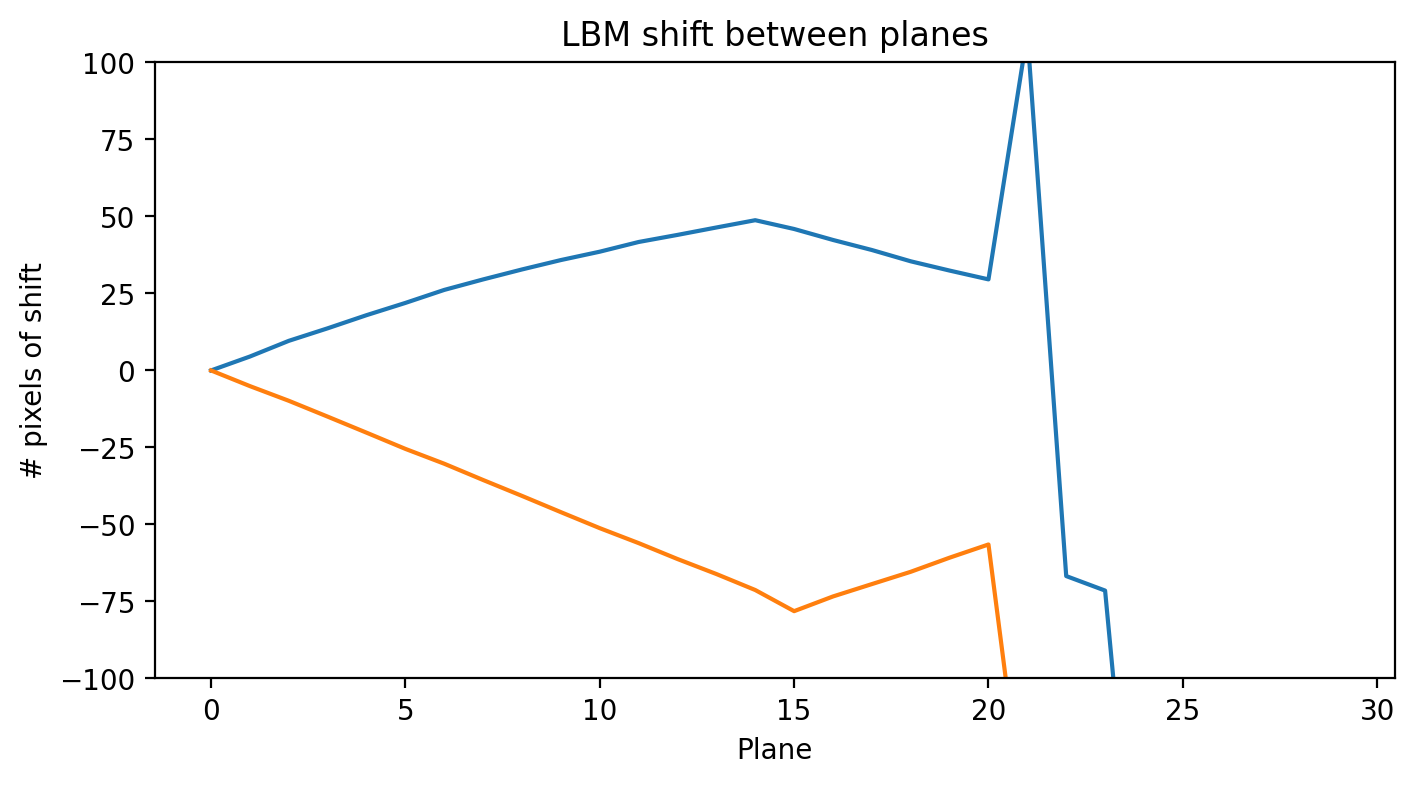

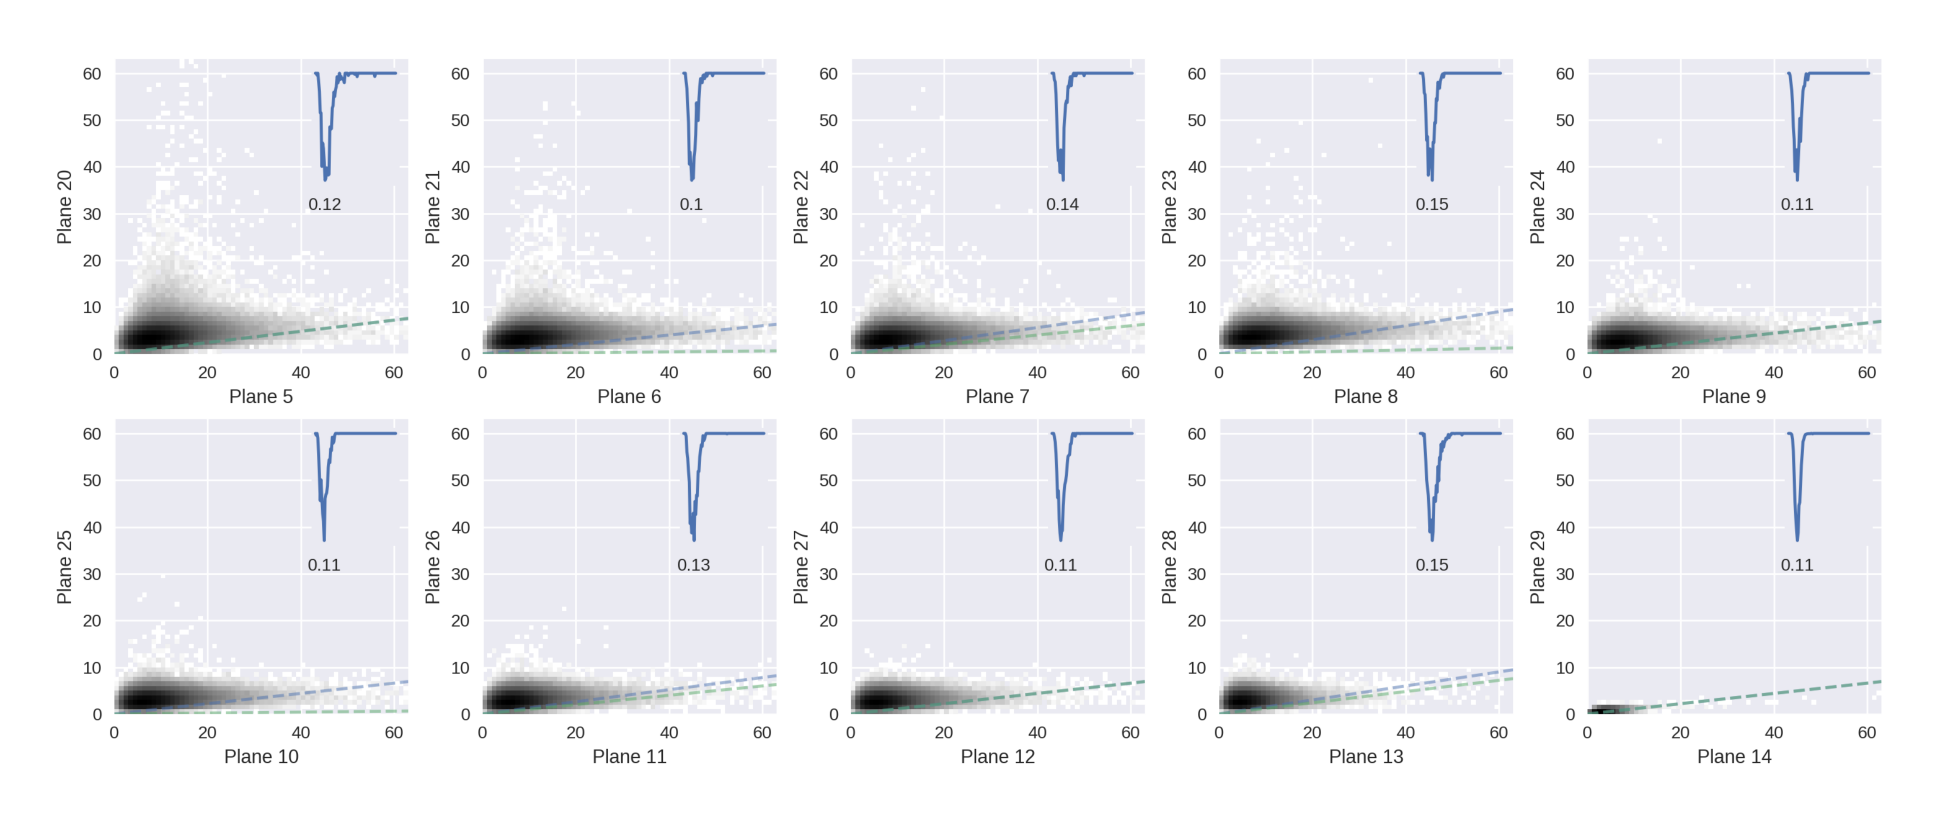

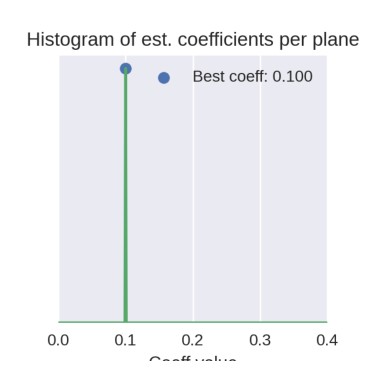

In [8]:
job.show_summary_plots()

In [16]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100
# FUSING: fuse the strips from the FOV into one image
# this is the number of pixels to skip between pixels, 13 makes it look relatively smooth
job.params['n_skip'] = 13
# should only fuse files where the plane_shifts look good, otherwise you might get an error
job.params['fuse_crop'] = ((0,20), (0,584), (0,584))

In [17]:
%%time
job.register()
job.fuse_registered_movie()

   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/registered_data
   Updated main params file
Will analyze 1 tifs in 1 batches
   Enforcing positivity
   Launching IO thread
      Loading /mnt/md0/data/Coconut/Max30_500umdeep_1p75by1p75mm_3umppix_9p86Hz_250mW_00001_00001.tif
         Start Batch:        Total Used: 121.697 GB, Virtual Available: 381.501 GB, Virtual Used: 121.696 GB, Swap Used: 000.001 GB
Loading Batch 1 of 1


<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in a

   Loaded 1 files, total 18.79 GB
   Batch 0 IO thread joined
         After IO thread joinTotal Used: 140.480 GB, Virtual Available: 362.718 GB, Virtual Used: 140.479 GB, Swap Used: 000.001 GB
   Subtracting min vals to enfore positivity
         After Sharr creation:Total Used: 159.307 GB, Virtual Available: 343.891 GB, Virtual Used: 159.305 GB, Swap Used: 000.001 GB
      Subtracting plane 1 from 16
      Subtracting plane 2 from 17
      Subtracting plane 3 from 18
      Subtracting plane 4 from 19
      Subtracting plane 5 from 20
      Subtracting plane 6 from 21
      Subtracting plane 7 from 22
      Subtracting plane 8 from 23
      Subtracting plane 9 from 24
      Subtracting plane 10 from 25
      Subtracting plane 11 from 26
      Subtracting plane 12 from 27
      Subtracting plane 13 from 28
      Subtracting plane 14 from 29
   Registering Batch 0
         Before Reg:         Total Used: 159.295 GB, Virtual Available: 343.903 GB, Virtual Used: 159.294 GB, Swap Used: 000

<tifffile.TiffFile 'Max30_500umdeep…_00001_00001.tif'> asarray failed to reshape (29580, 2414, 146) to (36000, 30, 2414, 146)


      Found dir /mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data with tag registered_fused_data
   Saving to /mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data
   Updated main params file
   Cropping: ((0, 20), (0, 584), (0, 584))
CPU times: user 1h 36min 58s, sys: 2h 39min 56s, total: 4h 16min 55s
Wall time: 17min 41s


['/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0000.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0001.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0002.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0003.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0004.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0005.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0006.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0007.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0008.npy',
 '/mnt/md0/runs/s3d-Coconut-Demo/registered_fused_data/fused_reg_data0009.npy']

In [9]:
mov_full = job.get_registered_movie()
im_full = mov_full[:,:1000].mean(axis=1).compute()

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f8c09973130>)

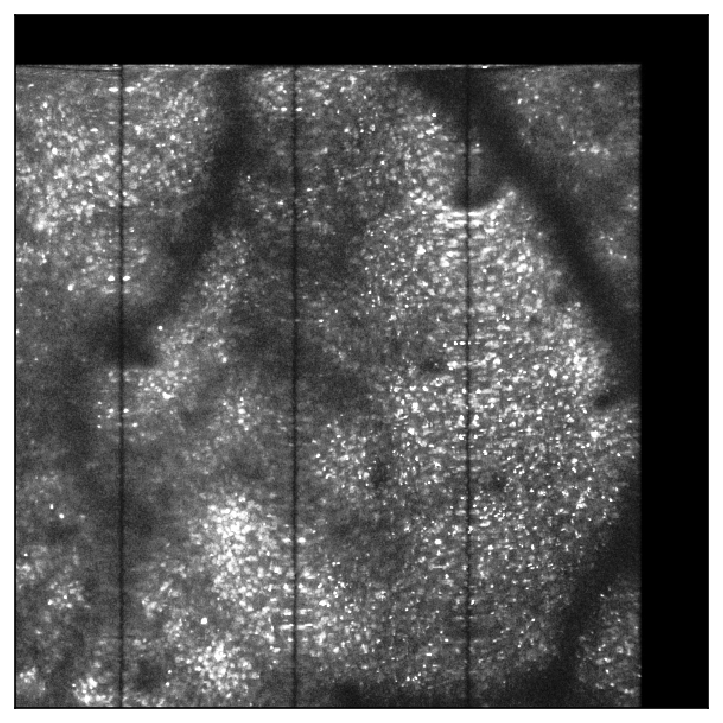

In [12]:
tfu.show_tif(im_full[11])

In [14]:
job.params['n_svd_comp'] = 500
job.params['svd_crop'] = ((0,20), (55,584), (0, 460))
job.params['svd_block_shape'] = (4,200,200)
job.params['svd_block_overlaps'] = (2,100,100)
svd_dir_tag = 'svd_cropped_2'

In [21]:
job.make_new_dir(svd_dir_tag)
svd_info = job.svd_decompose_movie(svd_dir_tag, run_svd=True)

      Found dir /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2 with tag svd_cropped_2
   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2
   Updated main params file
   Cropped to size (20, 986, 529, 460)
   Time-cropped to size (20, 986, 529, 460)
   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2
   Updated main params file
180 blocks with overlap (45 without, 4.00x increase)
   Will compute SVD in 180 blocks in a grid shaped (9, 5, 4)
   Batching 1 blocks together, for a total of 180 batches. Pix chunksize: 80000
   Saving SVD blocks in /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/blocks
Starting with batch 0
      Starting batch 1 / 180, blocks 0 - 1
      Sending batch 1 to dask
      Dask completed in 7.391 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 1 completed in 7.428
   Estimated time remaining for 179 batches: 00h22m09s
      Starting batch 2 / 180, blocks 1 - 2
      Sending batch

      Dask completed in 8.413 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 28 completed in 8.443
   Estimated time remaining for 152 batches: 00h18m51s
      Starting batch 29 / 180, blocks 28 - 29
      Sending batch 29 to dask
      Dask completed in 7.177 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 29 completed in 7.207
   Estimated time remaining for 151 batches: 00h18m36s
      Starting batch 30 / 180, blocks 29 - 30
      Sending batch 30 to dask
      Dask completed in 8.695 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 30 completed in 8.724
   Estimated time remaining for 150 batches: 00h19m09s
      Starting batch 31 / 180, blocks 30 - 31
      Sending batch 31 to dask
      Dask completed in 6.532 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 31 completed in 6.562
   Estimated

      Dask completed in 8.051 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 58 completed in 8.080
   Estimated time remaining for 122 batches: 00h15m18s
      Starting batch 59 / 180, blocks 58 - 59
      Sending batch 59 to dask
      Dask completed in 7.155 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 59 completed in 7.184
   Estimated time remaining for 121 batches: 00h15m02s
      Starting batch 60 / 180, blocks 59 - 60
      Sending batch 60 to dask
      Dask completed in 8.621 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 60 completed in 8.653
   Estimated time remaining for 120 batches: 00h15m23s
      Starting batch 61 / 180, blocks 60 - 61
      Sending batch 61 to dask
      Dask completed in 7.565 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 61 completed in 7.597
   Estimated

      Dask completed in 7.955 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 88 completed in 7.984
   Estimated time remaining for 92 batches: 00h11m59s
      Starting batch 89 / 180, blocks 88 - 89
      Sending batch 89 to dask
      Dask completed in 7.838 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 89 completed in 7.866
   Estimated time remaining for 91 batches: 00h11m52s
      Starting batch 90 / 180, blocks 89 - 90
      Sending batch 90 to dask
      Dask completed in 7.166 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 90 completed in 7.195
   Estimated time remaining for 90 batches: 00h11m33s
      Starting batch 91 / 180, blocks 90 - 91
      Sending batch 91 to dask
      Dask completed in 7.348 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 91 completed in 7.377
   Estimated ti

      Dask completed in 7.764 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 118 completed in 7.793
   Estimated time remaining for 62 batches: 00h07m56s
      Starting batch 119 / 180, blocks 118 - 119
      Sending batch 119 to dask
      Dask completed in 7.066 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 119 completed in 7.097
   Estimated time remaining for 61 batches: 00h07m41s
      Starting batch 120 / 180, blocks 119 - 120
      Sending batch 120 to dask
      Dask completed in 7.420 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 120 completed in 7.449
   Estimated time remaining for 60 batches: 00h07m32s
      Starting batch 121 / 180, blocks 120 - 121
      Sending batch 121 to dask
      Dask completed in 7.183 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 121 completed in 7.212

      Dask completed in 6.881 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 147 completed in 6.909
   Estimated time remaining for 33 batches: 00h04m00s
      Starting batch 148 / 180, blocks 147 - 148
      Sending batch 148 to dask
      Dask completed in 6.814 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 148 completed in 6.842
   Estimated time remaining for 32 batches: 00h03m50s
      Starting batch 149 / 180, blocks 148 - 149
      Sending batch 149 to dask
      Dask completed in 7.732 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 149 completed in 7.761
   Estimated time remaining for 31 batches: 00h03m46s
      Starting batch 150 / 180, blocks 149 - 150
      Sending batch 150 to dask
      Dask completed in 7.736 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 150 completed in 7.766

      Dask completed in 7.840 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 176 completed in 7.870
   Estimated time remaining for 4 batches: 00h00m30s
      Starting batch 177 / 180, blocks 176 - 177
      Sending batch 177 to dask
      Dask completed in 7.320 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 177 completed in 7.348
   Estimated time remaining for 3 batches: 00h00m22s
      Starting batch 178 / 180, blocks 177 - 178
      Sending batch 178 to dask
      Dask completed in 8.040 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 178 completed in 8.069
   Estimated time remaining for 2 batches: 00h00m15s
      Starting batch 179 / 180, blocks 178 - 179
      Sending batch 179 to dask
      Dask completed in 9.076 sec
      Saving svd_info to /mnt/md0/runs/s3d-Coconut-Demo/svd_cropped_2/svd_info.npy
   Batch 179 completed in 9.104
  

In [15]:
svd_info = n.load(os.path.join(job.dirs[svd_dir_tag], 'svd_info.npy'),allow_pickle=True).item()

In [16]:
job.params['t_batch_size'] = 400
job.params['n_proc_corr'] = 8
job.params['n_svd_comp'] = 200
job.params['intensity_thresh'] = 0.25

params_to_sweep = {
    'intensity_thresh' : (0.25, 0.4),
    'n_svd_comp' : (200,300,400),
}


In [17]:
sweep_summary = job.sweep_params(params_to_sweep, mov = svd_info,testing_dir_tag='sweep-01',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)
# v = job.vis_vmap_sweep(sweep_summary)

      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01 with tag sweep-01
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00000 with tag sweep-01-comb_00000
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00001 with tag sweep-01-comb_00001
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00002 with tag sweep-01-comb_00002
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00003 with tag sweep-01-comb_00003
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00004 with tag sweep-01-comb_00004
      Found dir /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00005 with tag sweep-01-comb_00005
   Saving summary for 6 combinations to /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep_summary.npy
Running combination 01/06Total Used: 113.098 GB, Virtual Available: 390.118 GB, Virtual Used: 113.079 GB, Swap Used: 000.019 GB
   Summary dict size: 00 GB
      Combination params: comb00000-params

Sending all blocks to dask to compute
Dask reconstruction complete
         Reconstructed in 86.83 seconds
      Loaded and swapped, idx 0 to 400
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
   Calculated corr map in 57.71 seconds
      Saving to /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00004/iters/batch0000
   Removing mov_sub from /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00004/mov_sub
Running combination 06/06Total Used: 113.812 GB, Virtual Available: 389.403 GB, Virtual Used: 113.793 GB, Swap Used: 000.019 GB
   Summary dict size: 00 GB
      Combination params: comb00005-params-intensity_thresh_0.400-n_svd_comp_400.000
      Saving to tag sweep-01-comb_00005 at /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00005
   Saved a copy of params at /mnt/md0/runs/s3d-Coconut-Demo/sweep-01/sweep-01-comb_00005
   Updated main params file
      Found dir /mnt/md0/ru

In [ ]:
sweep_summary = n.load(os.path.join(job.dirs['sweep-01'], 'sweep_summary.npy'),allow_pickle=True).item()

In [ ]:
v = job.vis_vmap_sweep(sweep_summary)

In [ ]:
job.params['intensity_thresh'] = 0.4
job.params['n_svd_comps'] = 300
job.params['t_batch_size'] = 300

In [ ]:
vmap, mean_img, max_img = job.calculate_corr_map(mov = svd_info)

In [ ]:
v = napari.view_image(vmap)
v.add_image(mean_img)

In [ ]:
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 5.8
job.params['percentile'] = 99.0
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.patch_and_detect(combined_name='combined-full')

In [ ]:
traces = job.extract_and_deconvolve(stats_dir = combined_dir)

In [14]:
combined_dir = job.dirs['detection-combined-full']

In [27]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
v,layers = ui.create_ui(outputs)
ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir)

Found old curated iscell with 18016 of 18107 marked as cells
Saving old iscell_curated to backup path Y:\runs\Coconut\s3d-Coconut-Demo\detection\combined-full\iscell_curated_old_09-06-23_12-59-09.npy
Cells
Saving old iscell_curated to backup path Y:\runs\Coconut\s3d-Coconut-Demo\detection\combined-full\iscell_curated_slider_old_09-06-23_12-59-09.npy
('vmap_peak', (5.800059, 7.1653999328613285), 'peak_val', <function add_curation_sliders.<locals>.<lambda> at 0x000001B85597DE50>)
10267 cells valid
Cells
Updating cell 9617
10266 cells valid
Cells
Updating cell 9382
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 10505
10265 cells valid
Cells
Updating cell 10309
10265 cells valid
Cells
Updating cell 16716
10264 cells valid
Cells
Updating cell 12139
10263 cells valid
Cells
Updating cell 12202
10262 cells valid
Cells
Updating ce

In [54]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
outputs['F'].shape

(18107, 9860)

In [57]:
v1, v2 = ui.make_label_vols(outputs['stats'], outputs['vmap'].shape, 
            iscell =  outputs['iscell_curated_slider'], 
                  cmap='Blues', lam_max = 0.3)

In [58]:
tfu.save_mrc(combined_dir, 'curated_cells.mrc',v2[:,:,:,3], voxel_size=(4,4,15))